In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import ast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
import os

In [2]:
class SASRec(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.vocab_size = args.vocab_size
        self.max_len = args.max_len
        self.hidden = args.hidden_units
        self.heads = args.num_heads
        self.layers = args.num_layers
        self.dropout_rate = args.dropout_rate

        self.item_emb = nn.Embedding(self.vocab_size + 1, self.hidden, padding_idx=0)
        self.pos_emb = nn.Embedding(self.max_len, self.hidden)
        self.emb_dropout = nn.Dropout(self.dropout_rate)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden,
            nhead=self.heads,
            dim_feedforward=self.hidden * 4,
            dropout=self.dropout_rate,
            activation='relu',
            batch_first=True,
            norm_first=True 
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.layers)
        
        self.last_layernorm = nn.LayerNorm(self.hidden)
        
        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, log_seqs):
        batch_size, seq_len = log_seqs.size()
        device = log_seqs.device

        padding_mask = (log_seqs == 0)
        
        attention_mask = ~torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device))

        pos_ids = torch.arange(seq_len, dtype=torch.long, device=device)
        pos_ids = pos_ids.unsqueeze(0).expand(batch_size, -1)

        seqs = self.item_emb(log_seqs) + self.pos_emb(pos_ids)
        seqs = self.emb_dropout(seqs)

        output = self.transformer_encoder(seqs, mask=attention_mask, src_key_padding_mask=padding_mask)
        output = self.last_layernorm(output)

        logits = torch.matmul(output, self.item_emb.weight.transpose(0, 1))
        return logits

In [3]:
class SASRecDataset(Dataset):
    def __init__(self, user_sequences, args, partition='train', seed=42):
        self.max_len = args.max_len
        self.vocab_size = args.vocab_size
        
        total_len = len(user_sequences)
        indices = np.arange(total_len)
        rs = np.random.RandomState(seed)
        rs.shuffle(indices)
        
        train_end = int(total_len * 0.75)
        val_end = int(total_len * 0.875)

        if partition == 'train':
            self.user_sequences = [user_sequences[i] for i in indices[:train_end]]
            self.is_training = True
        elif partition == 'val':
            self.user_sequences = [user_sequences[i] for i in indices[train_end:val_end]]
            self.is_training = False
        elif partition == 'test':
            self.user_sequences = [user_sequences[i] for i in indices[val_end:]]
            self.is_training = False

    def __len__(self):
        return len(self.user_sequences)

    def __getitem__(self, idx):
        seq = self.user_sequences[idx]
        
        if self.is_training:
            if len(seq) > self.max_len + 1:
                seq = seq[-(self.max_len + 1):]

            tokens = seq[:-1]
            labels = seq[1:] 

            padding_len = self.max_len - len(tokens)
            tokens = [0] * padding_len + tokens
            labels = [0] * padding_len + labels
            
            return torch.LongTensor(tokens), torch.LongTensor(labels)

        else:
            answer_item = seq[-1]
            input_seq = seq[:-1]
            
            if len(input_seq) > self.max_len:
                input_seq = input_seq[-self.max_len:]
                
            padding_len = self.max_len - len(input_seq)
            tokens = [0] * padding_len + input_seq
            
            return torch.LongTensor(tokens), torch.tensor(answer_item)

In [4]:
def evaluate_SASREC(model, dataloader, device, k_list=[1, 5, 10]):
    model.eval()
    metric_names = ['MRR'] + [f'HR@{k}' for k in k_list] + [f'NDCG@{k}' for k in k_list]
    accumulated_metrics = {name: [] for name in metric_names}

    with torch.no_grad():
        for seqs, labels in dataloader:
            seqs, labels = seqs.to(device), labels.to(device)

            logits = model(seqs)

            last_logits = logits[:, -1, :]

            batch_metrics = calculate_metrics(last_logits, labels, k_list)

            for k, v in batch_metrics.items():
                accumulated_metrics[k].append(v)

    return {k: np.mean(v) for k, v in accumulated_metrics.items()}

In [5]:
class Args:
    vocab_size = 1019  
    max_len = 100       
    hidden_units = 128   
    num_heads = 1       
    num_layers = 2     
    dropout_rate = 0.1 
    batch_size = 128
    lr = 0.0001
    epochs = 100        

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def calculate_metrics(logits, labels, k_list=[1, 5, 10]):
    """
    logits: [batch, vocab_size] (Output at the masked position)
    labels: [batch] (The ground truth item)
    """
    max_k = max(k_list)
    
    # Mask padding and special tokens in prediction
    # (Assuming 0 is PAD, vocab_size+1 is MASK)
    logits[:, 0] = -float('inf')
    if logits.size(1) > args.vocab_size + 1:
        logits[:, args.vocab_size + 1] = -float('inf')

    # Get Top-K
    _, topk_indices = torch.topk(logits, k=max_k, dim=-1) # [batch, max_k]

    # Create Hit Matrix
    # labels.unsqueeze(1): [batch, 1]
    hits = (topk_indices == labels.unsqueeze(1)) # [batch, max_k]

    metrics = {}

    # --- MRR ---
    # Find the rank of the first hit
    hit_ranks = hits.nonzero() # [n_hits, 2] -> (batch_idx, rank_idx)
    mrr = torch.zeros(logits.size(0), device=logits.device)
    
    # rank_idx is 0-based, so reciprocal is 1/(rank+1)
    if hit_ranks.size(0) > 0:
        reciprocal_ranks = 1.0 / (hit_ranks[:, 1].float() + 1.0)
        mrr[hit_ranks[:, 0]] = reciprocal_ranks
    metrics['MRR'] = mrr.mean().item()

    # --- HR & NDCG ---
    for k in k_list:
        hits_k = hits[:, :k] # [batch, k]
        
        # HR@K
        hr_k = hits_k.sum(dim=1)
        # Cap at 1.0 (though with unique items it is already 0 or 1)
        hr_k[hr_k > 1] = 1 
        metrics[f'HR@{k}'] = hr_k.float().mean().item()

        # NDCG@K
        # For single target, IDCG=1. DCG = 1/log2(rank+1) if hit.
        position_weights = 1.0 / torch.log2(torch.arange(2, k + 2, device=logits.device).float())
        dcg = (hits_k.float() * position_weights).sum(dim=1)
        metrics[f'NDCG@{k}'] = dcg.mean().item()

    return metrics

In [7]:
print("Loading Parquet files...")
netflix_df = pd.read_parquet('/kaggle/input/datasets/yassineblaiech/history-datasets/user_history_netflix.parquet')
ml_df = pd.read_parquet('/kaggle/input/datasets/yassineblaiech/history-datasets/user_history_ml.parquet')
combined_df = pd.read_parquet('/kaggle/input/datasets/yassineblaiech/history-datasets/user_history.parquet')

def extract_user_sequence_from_parquet(user_history):
    all_movies = [movie for seq in user_history['list_movies'] for movie in seq]
    
    unique_movies = sorted(list(set(all_movies)))
    movie_to_id = {movie: i + 1 for i, movie in enumerate(unique_movies)}
    
    user_sequences = user_history['list_movies'].apply(
        lambda seq: [movie_to_id[m] for m in seq]
    ).tolist()
    
    vocab_size = len(unique_movies)
    print(f"   -> Found {len(user_sequences)} sequences.")
    print(f"   -> Vocab Size is {vocab_size}")
    
    return user_sequences, vocab_size


# Preprocess Sequences
print("Extracting sequences...")
netflix_sequences, netflix_vocab = extract_user_sequence_from_parquet(netflix_df)
ml_sequences, ml_vocab = extract_user_sequence_from_parquet(ml_df)
combined_sequences, combined_vocab = extract_user_sequence_from_parquet(combined_df)



Loading Parquet files...
Extracting sequences...
   -> Found 239012 sequences.
   -> Vocab Size is 1019
   -> Found 200948 sequences.
   -> Vocab Size is 59137
   -> Found 439960 sequences.
   -> Vocab Size is 59751


In [8]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda)

def run_sasrec_training_pipeline(dataset_name, sequences, vocab_size, args):
    print(f"\n{'='*40}")
    print(f"Starting SASRec Run: {dataset_name.upper()}")
    print(f"{'='*40}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    save_path = f'sasrec_{dataset_name}_best.pth'

    # --- Data Splitting ---
    total_users = len(sequences)
    indices = np.arange(total_users)
    np.random.shuffle(indices)

    train_end = int(total_users * 0.8)
    val_end = int(total_users * 0.9)

    train_seqs = [sequences[i] for i in indices[:train_end]]
    val_seqs   = [sequences[i] for i in indices[train_end:val_end]]
    test_seqs  = [sequences[i] for i in indices[val_end:]]

    print(f"Total Users: {total_users}")
    print(f"Train: {len(train_seqs)} | Val: {len(val_seqs)} | Test: {len(test_seqs)}")

    train_data = SASRecDataset(train_seqs, args, partition='train')
    val_data   = SASRecDataset(val_seqs, args, partition='val')
    test_data  = SASRecDataset(test_seqs, args, partition='test')

    train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    val_dataloader   = DataLoader(val_data, batch_size=args.batch_size, shuffle=False)
    test_dataloader  = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

    # --- Model Setup ---
    model = SASRec(args).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    # --- Optimizer & Scheduler (Updated to AdamW + Warmup) ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    
    total_steps = len(train_dataloader) * args.epochs
    warmup_steps = int(total_steps * 0.1) 
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0) 

    eval_k_list = [1, 5, 10]
    best_ndcg = 0.0
    history = {'train_loss': [], 'val_ndcg10': [], 'val_hr10': []}

    # --- Training Loop ---
    print(f"Training on {device}...")
    for epoch in range(args.epochs):
        model.train()
        total_loss = 0

        for step, (seqs, labels) in enumerate(train_dataloader):
            seqs, labels = seqs.to(device), labels.to(device)
            
            logits = model(seqs) 
            # SASRec typically uses vocab_size + 1 (for 0 padding)
            loss = criterion(logits.view(-1, args.vocab_size + 1), labels.view(-1))

            optimizer.zero_grad()
            loss.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            scheduler.step() 
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        current_lr = scheduler.get_last_lr()[0]
        
        # Validation
        val_metrics = evaluate_SASREC(model, val_dataloader, device, k_list=eval_k_list)
        
        print(f"Epoch {epoch+1}/{args.epochs} | Loss: {avg_loss:.4f} | Val NDCG@10: {val_metrics['NDCG@10']:.4f} | LR: {current_lr:.6f}")

        history['train_loss'].append(avg_loss)
        history['val_ndcg10'].append(val_metrics['NDCG@10'])
        history['val_hr10'].append(val_metrics['HR@10'])

        if val_metrics['NDCG@10'] > best_ndcg:
            best_ndcg = val_metrics['NDCG@10']
            state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state_dict, save_path)
            print(f"  -> Best model saved to {save_path}")

    # --- Final Testing & Plotting ---
    print("\nLoading best model for Testing...")
    state_dict = torch.load(save_path)
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(state_dict)
    else:
        model.load_state_dict(state_dict)

    test_metrics = evaluate_SASREC(model, test_dataloader, device, k_list=eval_k_list)

    # Plotting Logic
    epochs_range = range(1, args.epochs + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Ax1: Learning Curve
    ax1.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', color='tab:red')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.set_xlabel('Epochs')
    ax1.set_title(f'Learning Curve ({dataset_name} - SASRec)')
    
    ax1_right = ax1.twinx()
    ax1_right.plot(epochs_range, history['val_ndcg10'], label='Val NDCG@10', marker='s', color='tab:blue')
    ax1_right.set_ylabel('NDCG@10', color='tab:blue')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_right.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    ax1.grid(True, alpha=0.3)

    # Ax2: Final Metrics
    metric_names = sorted(list(test_metrics.keys()))
    metric_values = [test_metrics[k] for k in metric_names]
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(metric_names)))
    bars = ax2.bar(metric_names, metric_values, color=colors)
    
    ax2.set_title(f'Final Test Metrics ({dataset_name})')
    ax2.set_ylim(0, 1.1) 
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("-" * 30)
    print(f"FINAL TEST RESULTS: {dataset_name}")
    for k, v in test_metrics.items():
        print(f"{k:<10}: {v:.4f}")
    print("-" * 30)
    
    return test_metrics


Starting SASRec Run: NETFLIX_PRIZE
Total Users: 239012
Train: 191209 | Val: 23901 | Test: 23902
Training on cuda...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/100 | Loss: 6.6045 | Val NDCG@10: 0.0641 | LR: 0.000010
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 2/100 | Loss: 5.5823 | Val NDCG@10: 0.1142 | LR: 0.000020
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 3/100 | Loss: 5.3139 | Val NDCG@10: 0.1842 | LR: 0.000030
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 4/100 | Loss: 5.1438 | Val NDCG@10: 0.2168 | LR: 0.000040
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 5/100 | Loss: 4.9471 | Val NDCG@10: 0.2348 | LR: 0.000050
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 6/100 | Loss: 4.8169 | Val NDCG@10: 0.2543 | LR: 0.000060
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 7/100 | Loss: 4.7296 | Val NDCG@10: 0.2627 | LR: 0.000070
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 8/100 | Loss: 4.6631 | Val NDCG@10: 0.2683 | LR: 0.000080
  -> Best model saved to sasrec_netflix_prize_best.pth
Epoch 9/100 | Loss: 4.6136 | Val NDCG@10: 0.2777

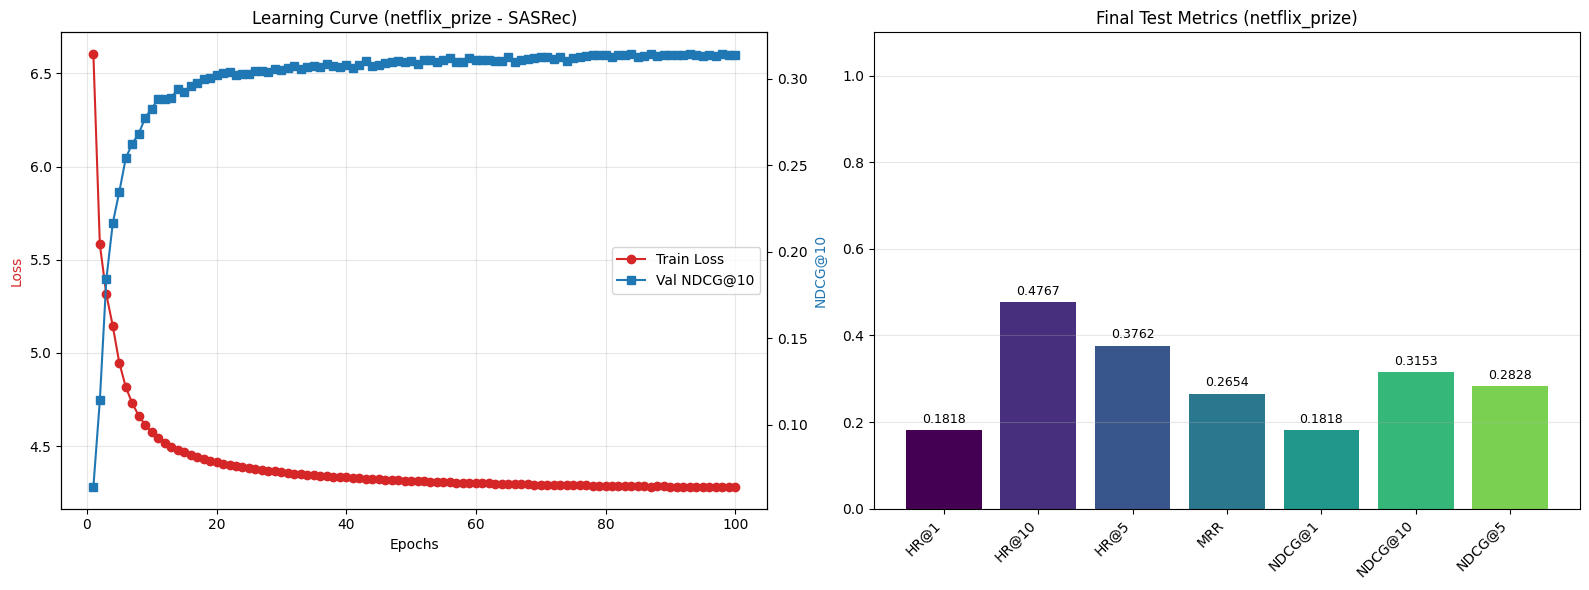

------------------------------
FINAL TEST RESULTS: netflix_prize
MRR       : 0.2654
HR@1      : 0.1818
HR@5      : 0.3762
HR@10     : 0.4767
NDCG@1    : 0.1818
NDCG@5    : 0.2828
NDCG@10   : 0.3153
------------------------------


{'MRR': np.float64(0.26535880379378796),
 'HR@1': np.float64(0.1818181819592913),
 'HR@5': np.float64(0.37624289840459824),
 'HR@10': np.float64(0.4767400572697322),
 'NDCG@1': np.float64(0.1818181819592913),
 'NDCG@5': np.float64(0.2827940055479606),
 'NDCG@10': np.float64(0.31530357462664443)}

In [69]:
run_sasrec_training_pipeline("netflix_prize", netflix_sequences, netflix_vocab, args)

In [9]:
class Args:
    vocab_size = ml_vocab  
    max_len = 100       
    hidden_units = 128   
    num_heads = 1       
    num_layers = 2     
    dropout_rate = 0.1 
    batch_size = 128
    lr = 0.0001
    epochs = 50       

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Starting SASRec Run: ML-32M
Total Users: 200948
Train: 160758 | Val: 20095 | Test: 20095


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Training on cuda...
Epoch 1/50 | Loss: 10.3898 | Val NDCG@10: 0.0107 | LR: 0.000020
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 2/50 | Loss: 8.5186 | Val NDCG@10: 0.0090 | LR: 0.000040
Epoch 3/50 | Loss: 7.9437 | Val NDCG@10: 0.0220 | LR: 0.000060
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 4/50 | Loss: 7.0340 | Val NDCG@10: 0.0929 | LR: 0.000080
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 5/50 | Loss: 6.0335 | Val NDCG@10: 0.1643 | LR: 0.000100
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 6/50 | Loss: 5.3400 | Val NDCG@10: 0.1910 | LR: 0.000098
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 7/50 | Loss: 4.9770 | Val NDCG@10: 0.2126 | LR: 0.000096
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 8/50 | Loss: 4.7445 | Val NDCG@10: 0.2292 | LR: 0.000093
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 9/50 | Loss: 4.5860 | Val NDCG@10: 0.2449 | LR: 0.000091
  -> Best model saved to sasrec_ML-32M_best.pth
Epoch 10/50 | Loss: 4.4728 |

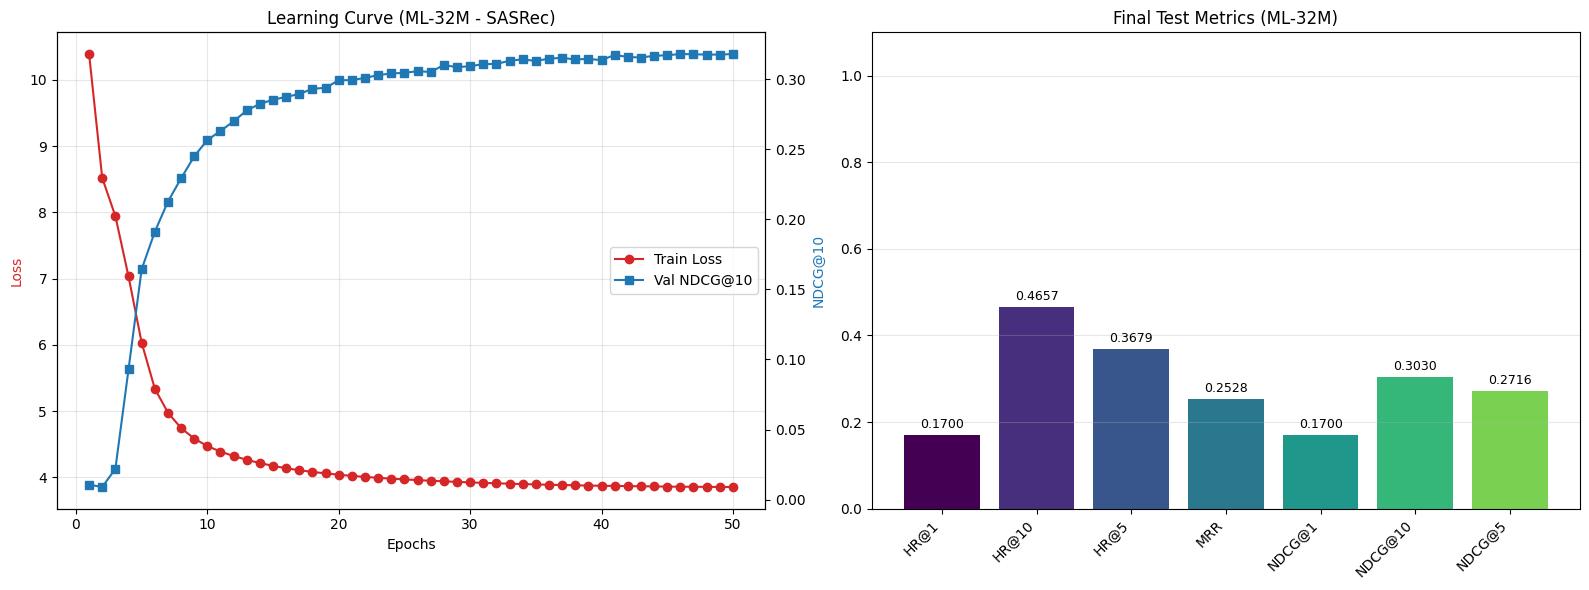

------------------------------
FINAL TEST RESULTS: ML-32M
MRR       : 0.2528
HR@1      : 0.1700
HR@5      : 0.3679
HR@10     : 0.4657
NDCG@1    : 0.1700
NDCG@5    : 0.2716
NDCG@10   : 0.3030
------------------------------


{'MRR': np.float64(0.25275940001010894),
 'HR@1': np.float64(0.17000000029802323),
 'HR@5': np.float64(0.36789062470197675),
 'HR@10': np.float64(0.4657031252980232),
 'NDCG@1': np.float64(0.17000000029802323),
 'NDCG@5': np.float64(0.2716479979455471),
 'NDCG@10': np.float64(0.30301321744918824)}

In [10]:
run_sasrec_training_pipeline("ML-32M", ml_sequences, ml_vocab, args)

In [9]:
class Args:
    vocab_size = combined_vocab  
    max_len = 100       
    hidden_units = 128   
    num_heads = 1       
    num_layers = 2     
    dropout_rate = 0.1 
    batch_size = 64
    lr = 0.0001
    epochs = 50    

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Starting SASRec Run: ML-32M + NETFLIX
Total Users: 439960
Train: 351968 | Val: 43996 | Test: 43996


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Training on cuda...
Epoch 1/50 | Loss: 9.4372 | Val NDCG@10: 0.0487 | LR: 0.000020
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 2/50 | Loss: 7.3586 | Val NDCG@10: 0.0752 | LR: 0.000040
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 3/50 | Loss: 6.0178 | Val NDCG@10: 0.1712 | LR: 0.000060
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 4/50 | Loss: 5.1837 | Val NDCG@10: 0.2059 | LR: 0.000080
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 5/50 | Loss: 4.7754 | Val NDCG@10: 0.2292 | LR: 0.000100
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 6/50 | Loss: 4.5338 | Val NDCG@10: 0.2479 | LR: 0.000098
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 7/50 | Loss: 4.3917 | Val NDCG@10: 0.2627 | LR: 0.000096
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 8/50 | Loss: 4.2982 | Val NDCG@10: 0.2685 | LR: 0.000093
  -> Best model saved to sasrec_ML-32M + netflix_best.pth
Epoch 9/50 |

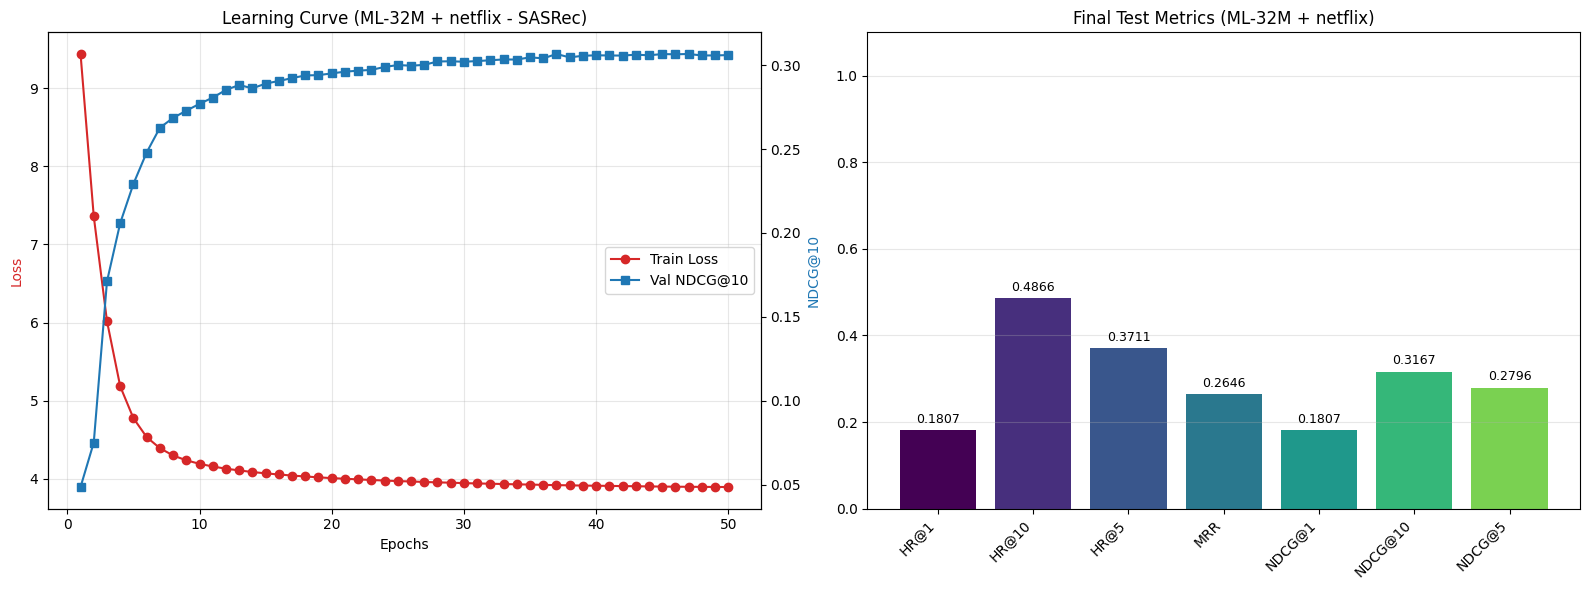

------------------------------
FINAL TEST RESULTS: ML-32M + netflix
MRR       : 0.2646
HR@1      : 0.1807
HR@5      : 0.3711
HR@10     : 0.4866
NDCG@1    : 0.1807
NDCG@5    : 0.2796
NDCG@10   : 0.3167
------------------------------


{'MRR': np.float64(0.2646089204868605),
 'HR@1': np.float64(0.18074127927769063),
 'HR@5': np.float64(0.3711361438035965),
 'HR@10': np.float64(0.48655523255813954),
 'NDCG@1': np.float64(0.18074127927769063),
 'NDCG@5': np.float64(0.2795854025455408),
 'NDCG@10': np.float64(0.3167496503785599)}

In [10]:
run_sasrec_training_pipeline("ML-32M + netflix", combined_sequences, combined_vocab, args)